Fauzan Akmal Mahdi

In [1]:
import pandas as pd                

Panggil dataset dan beri header

In [2]:
# dataset didapat dari link berikut https://zenodo.org/record/3355823#.YMyyV_LiuUk
filename = 'ecommerceDataset.csv'

#beri header
header = ['label', 'sentence']

#baca file menjadi dataframe
df = pd.read_csv(filename, names=header)

In [3]:
df

,label,sentence
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


Karena data berbentuk kategorikal maka dilakukan tahap
;
Tahap: One Hot Encoding dan membuat dataframe baru

In [5]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')
#50 ribu baris diambil sekitar 0.05 sehingga data berisi sekitar 2500 baris
df_baru = df_baru.sample(frac=0.05)

In [6]:
df_baru

,sentence,Books,Clothing & Accessories,Electronics,Household
46077,Skylight,0,0,1,0
16665,"Tool Point Silicon Waves Analogue Circuit AC, ...",0,0,0,1
1511,Spacewood Winner Study Table (Natural Wenge) S...,0,0,0,1
47129,Andride Universal Bike Holder 360 Degree Rotat...,0,0,1,0
45372,"Generic Pro 1/4"" Mount Adapter for Tripod Scre...",0,0,1,0
...,...,...,...,...,...
29573,Olympiad Books Practice Sets - English class 8...,1,0,0,0
30963,Oswaal CBSE Solved Papers Class 12 English Cor...,1,0,0,0
19424,Dance Dance Dance From Booklist There are only...,1,0,0,0
6900,Mystique Table Grace 2 Ply Napkin - 90 Serviet...,0,0,0,1


In [7]:
#ubah tipe kolom menjadi string agar bisa diolah oleh tokenizer
kalimat = df_baru['sentence'].astype(str)
label = df_baru[['Books','Clothing & Accessories','Electronics','Household']].values
#label = df['label'].values

Membagi data training dan data testing

In [16]:
#bagi data dengan library sklearn.model_selection, data testing 0.2 atau sekitar 500 data
from sklearn.model_selection import train_test_split
kalimat_latih, kalimat_test, label_latih, label_test = train_test_split(kalimat, label, test_size=0.2)

Tokenisasi

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
#ambil 2000 data untuk dilakukan tokenisasi
tokenizer = Tokenizer(num_words=2000, oov_token="'")
tokenizer.fit_on_texts(kalimat_latih)
tokenizer.fit_on_texts(kalimat_test)

In [22]:
#ubah sekuens kalimat menjadi token
sekuens_latih = tokenizer.texts_to_sequences(kalimat_latih)
sekuens_test = tokenizer.texts_to_sequences(kalimat_test)

Embedding

In [23]:
#beri padding agar sama rata
padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

Membuat Model

In [43]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=2000, output_dim=16),  #input dimensi sebesar jumlah kata yang ditokenisasi & dimensi embedding 16
    tf.keras.layers.LSTM(128), #dimensi output 64
    tf.keras.layers.Dense(128, activation='relu'), #layer dengan 128 perceptron
    tf.keras.layers.Dense(32, activation='relu'), #layer dengan 32 perceptron
    tf.keras.layers.Dense(32, activation='relu'), #layer dengan 32 perceptron
    tf.keras.layers.Dense(4, activation='softmax') # layer output dengan 4 perceptron
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Buat Kelas Callback

In [44]:
#buat kelas callback untuk mempercepat proses tuning
class myCallback(tf.keras.callbacks.Callback ):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

Fit Model

In [45]:
#15 epochs
num_epochs = 15
#fitting model dengan batchsize 128 dan menggunakan callback
history = model.fit(padded_latih, label_latih, 
                    epochs=num_epochs, batch_size=128, 
                    validation_data=(padded_test, label_test), 
                    verbose=2, callbacks=[callbacks])

Epoch 1/15
16/16 - 142s - loss: 1.3670 - accuracy: 0.3800 - val_loss: 1.3311 - val_accuracy: 0.4000
Epoch 2/15
16/16 - 131s - loss: 1.3119 - accuracy: 0.4087 - val_loss: 1.2721 - val_accuracy: 0.4317
Epoch 3/15
16/16 - 128s - loss: 1.1999 - accuracy: 0.4931 - val_loss: 1.0946 - val_accuracy: 0.5505
Epoch 4/15
16/16 - 121s - loss: 1.0021 - accuracy: 0.5670 - val_loss: 0.9003 - val_accuracy: 0.6000
Epoch 5/15
16/16 - 128s - loss: 0.8223 - accuracy: 0.6161 - val_loss: 0.7998 - val_accuracy: 0.6832
Epoch 6/15
16/16 - 115s - loss: 0.7464 - accuracy: 0.7331 - val_loss: 0.8027 - val_accuracy: 0.7327
Epoch 7/15
16/16 - 118s - loss: 0.4968 - accuracy: 0.8100 - val_loss: 0.5955 - val_accuracy: 0.8277
Epoch 8/15
16/16 - 121s - loss: 0.3465 - accuracy: 0.8854 - val_loss: 0.5427 - val_accuracy: 0.8455
Epoch 9/15
16/16 - 122s - loss: 0.2735 - accuracy: 0.9187 - val_loss: 0.5037 - val_accuracy: 0.8396

Akurasi telah mencapai >90%!


Plot Loss dan Akurasi dari Trained Model

Plot Loss

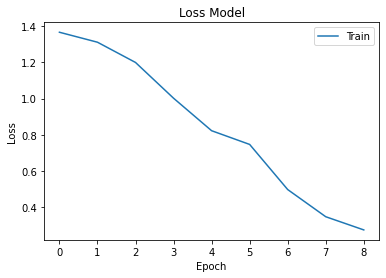

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

Plot Akurasi

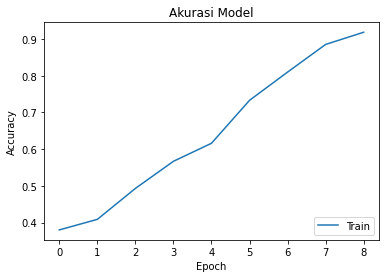

In [53]:
plt.plot(history.history['accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()